In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("../")

import torch
import transformers
import baukit
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.models import ModelandTokenizer
from src.functional import find_token_range

torch.__version__, transformers.__version__, torch.version.cuda

('2.1.2+cu121', '4.36.2', '12.1')

In [3]:
# MODEL_PATH = "EleutherAI/gpt-j-6B"
# MODEL_PATH = "meta-llama/Llama-2-7b-hf"
# MODEL_PATH = "mistralai/Mistral-7B-v0.1"


# from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel

MODEL_PATH = "state-spaces/mamba-2.8b-slimpj" # state-spaces/mamba-2.8b

mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

# mt.model.config

/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from src import functional

prompt = mt.tokenizer.eos_token + " Louvre located in the city of"

inputs = mt.tokenizer(prompt, return_tensors="pt", padding="longest").to(
    next(mt.model.parameters()).device
)

In [5]:
with torch.inference_mode():
    outputs = mt.model(input_ids=inputs.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

[(' Paris', 0.261),
 (' Abu', 0.049),
 (' Lyon', 0.019),
 (' Mar', 0.019),
 (' the', 0.018),
 (' L', 0.018),
 (' T', 0.014),
 (' Vers', 0.014),
 (' A', 0.012),
 (' D', 0.011)]

In [6]:
# import baukit

# # with torch.inference_mode():
# with baukit.TraceDict(
#     module = mt.model,
#     layers = ["backbone"] + mt.layer_names
# ) as traces:
#     outputs = mt.model(input_ids=inputs.input_ids)

# h = traces[mt.layer_names[-1]].output

# h_back = traces["backbone"].output

# # print(h[0][:,-1].shape)
# # print(h_back[0][-1].shape)

# torch.allclose(
#     mt.lm_head.final_layer_norm(x = h[0][:, -1], residual = h[1][:, -1]), 
#     h_back[0][-1]
# )

In [7]:
# h[0][:, -1].shape, h[1][:, -1].shape

### Confirmed! Mamba handles adding module contribution to the residual stream inside their implementation of Layernorm

In [8]:
# layer_norm = mt.lm_head.final_layer_norm

# usual_output = layer_norm.ln_f(h[0][:, -1] + h[1][:, -1])
# mamba_output = layer_norm(x = h[0][:, -1], residual = h[1][:, -1])

# torch.allclose(usual_output.to(mamba_output.dtype), mamba_output)

In [9]:
# logits = mt.lm_head(
#     x = h[0][:, -1], 
#     residual = h[1][:, -1]
# )
# logits

In [10]:
# logits_back = mt.lm_head.lm_head(h_back)
# logits_back[0][-1]

In [11]:
# outputs.logits[0][-1]

In [12]:
# functional.logit_lens(
#     mt = mt,
#     h = (h[0][:, -1], h[1][:, -1]),
#     get_proba=True
# )

### Check Causal Effect

In [13]:
prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"

In [14]:
subject = "The Space Needle"
prompt = prompt_template.format(subject)
inputs = mt.tokenizer(prompt, return_tensors="pt", return_offsets_mapping = True).to(
    next(mt.model.parameters()).device
)

offsets = inputs.pop("offset_mapping")
alt_subj_idx = find_token_range(
    string = prompt,
    substring=subject,
    offset_mapping=offsets[0]
)[-1]
print(f"{alt_subj_idx=}")

with torch.inference_mode():
    with baukit.TraceDict(
        module = mt.model,
        layers = mt.layer_names
    ) as alt_activations:
        outputs = mt.model(input_ids=inputs.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

alt_subj_idx=5


[(' Seattle', 0.98),
 (' Se', 0.002),
 (' the', 0.002),
 (' Sea', 0.001),
 (' se', 0.001),
 (' Century', 0.001),
 (' Space', 0.0),
 (' downtown', 0.0),
 (',', 0.0),
 (' Pu', 0.0)]

In [15]:
logits.shape

torch.Size([50280])

In [16]:
h = alt_activations[mt.layer_names[-1]].output[0, -1]
functional.logit_lens(
    mt = mt,
    h = h,
    get_proba=True
)

([(' Seattle', 0.98),
  (' Se', 0.002),
  (' the', 0.002),
  (' Sea', 0.001),
  (' se', 0.001),
  (' Century', 0.001),
  (' Space', 0.0),
  (' downtown', 0.0),
  (',', 0.0),
  (' Pu', 0.0)],
 {})

In [17]:
alt_activations[mt.layer_names[15]].output[:, alt_subj_idx].shape

torch.Size([1, 2560])

In [18]:
subject = "Big Ben"
prompt = prompt_template.format(subject)
inputs = mt.tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True).to(
    next(mt.model.parameters()).device
)

offsets = inputs.pop("offset_mapping")
subj_idx = find_token_range(
    string = prompt,
    substring=subject,
    offset_mapping=offsets[0]
)[-1]
print(f"{subj_idx=}")

with torch.inference_mode():
    outputs = mt.model(input_ids=inputs.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

subj_idx=3


[(' London', 0.442),
 (' Westminster', 0.055),
 (' Manchester', 0.017),
 (' Liverpool', 0.014),
 (' Leicester', 0.013),
 (' Birmingham', 0.012),
 (' New', 0.012),
 (' Washington', 0.012),
 (' Paris', 0.01),
 (' Edinburgh', 0.01)]

In [19]:
from typing import Callable
from src.functional import untuple

def patch_output(
    patch_layer: str, patch_idx: int, 
    patching_vector: torch.Tensor, 
    # patching_residual: torch.Tensor
) -> Callable:
    def edit_output(layer, output):
        if layer != patch_layer:
            return output
        untuple(output)[:, patch_idx] = patching_vector
        return output
        # y, residual = output
        # print(f" >>> {y.shape=} {y.dtype} | {residual.shape=} {residual.dtype}")
        # y[:, patch_idx] = patching_vector.to(y.dtype)
        # residual[:, patch_idx] = patching_residual.to(residual.dtype)
        # return y, residual

    return edit_output


# ! replacing the activation with alternate subject does not seem to have significant effect on the output
########################
replace_layer = 20
#######################
with torch.inference_mode():
    with baukit.TraceDict(
        module = mt.model,
        layers = mt.layer_names,
        edit_output= patch_output(
            patch_layer = mt.layer_names[replace_layer],
            patch_idx = subj_idx,
            patching_vector = alt_activations[mt.layer_names[replace_layer]].output[:, alt_subj_idx],
            # patching_residual= alt_activations[mt.layer_names[replace_layer]].output[1][:, alt_subj_idx]
        )
    ) as traces:
        outputs = mt.model(input_ids=inputs.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

[(' London', 0.522),
 (' Westminster', 0.185),
 (' Manchester', 0.012),
 (' Leicester', 0.01),
 (' Liverpool', 0.01),
 (' Paris', 0.009),
 (' Birmingham', 0.007),
 (' Washington', 0.007),
 (' Edinburgh', 0.006),
 (' New', 0.004)]

In [20]:
alt_sub_acts = alt_activations[mt.layer_names[replace_layer]].output[:, alt_subj_idx]
patched_sub_acts = traces[mt.layer_names[replace_layer]].output[:, subj_idx]

assert torch.allclose(alt_sub_acts, patched_sub_acts)

# alt_sub_res = alt_activations[mt.layer_names[replace_layer]].output[1][:, alt_subj_idx]
# patched_sub_res = traces[mt.layer_names[replace_layer]].output[1][:, subj_idx]

# assert torch.allclose(alt_sub_res, patched_sub_res)

In [7]:
from src.plotting import plot_hidden_flow

prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"

subject = "The Space Needle"
prompt = prompt_template.format(subject)


# find_token_range(
#     string = prompt,
#     substring=subject,
#     tokenizer=mt.tokenizer,
# )

In [8]:
# plot_hidden_flow(
#     mt,
#     prompt,
#     subject=subject,
#     kind = None,
#     model_name=mt.model_name.split("/")[-1],
# )

In [10]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt,
    subject = subject,
)

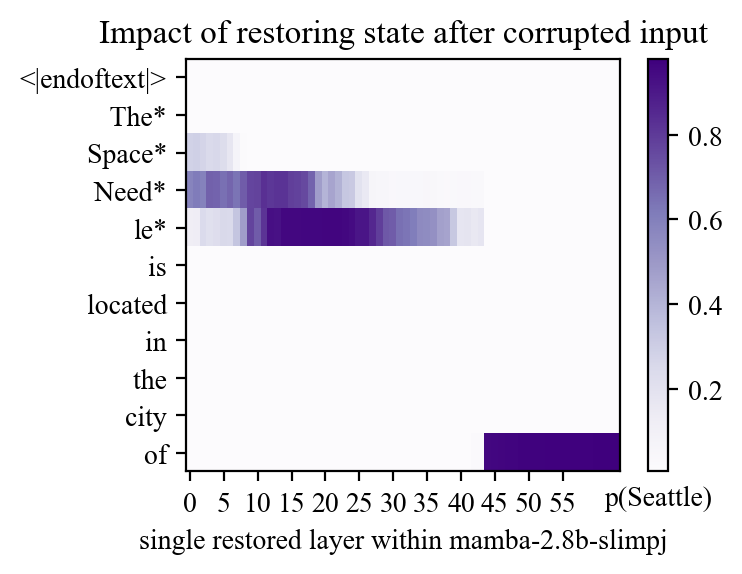

In [19]:
plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

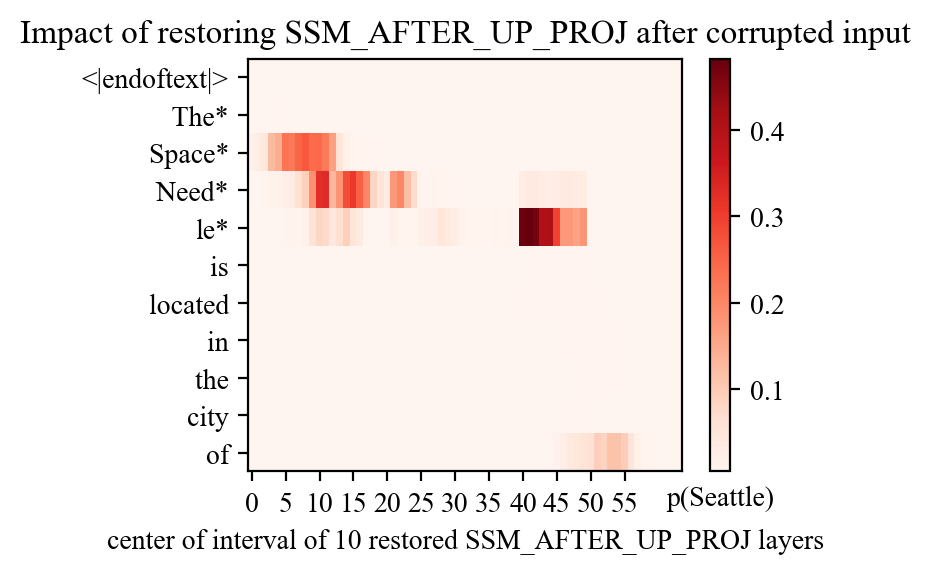

In [40]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

mt.reset_forward()

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt,
    subject = subject,
    mamba_block_hook="ssm_after_up_proj"
)

plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_up_proj'


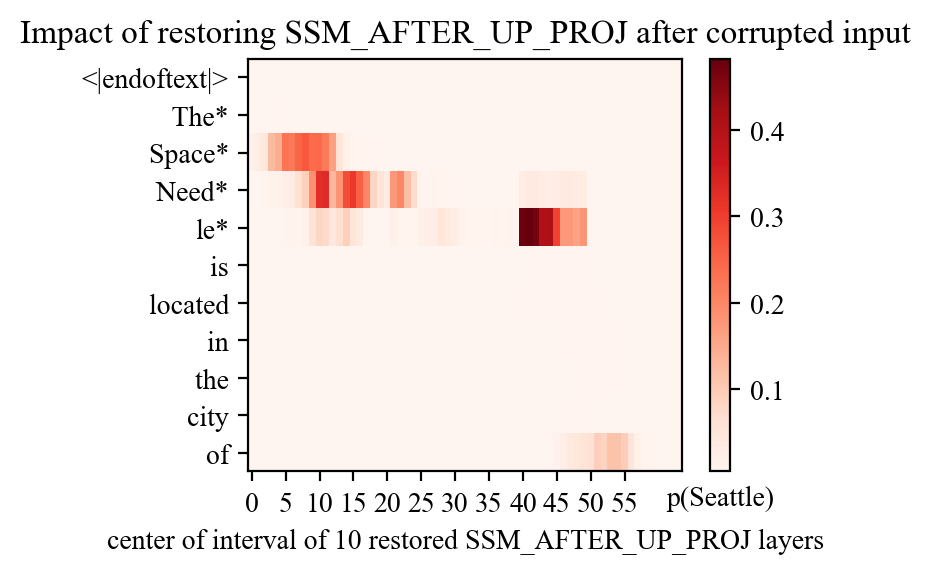

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_conv1D'


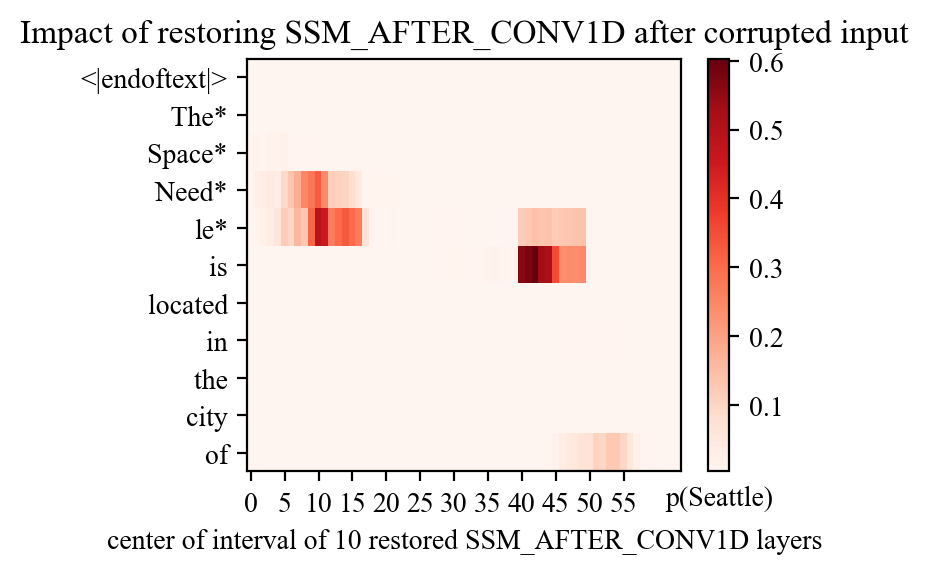

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_silu'


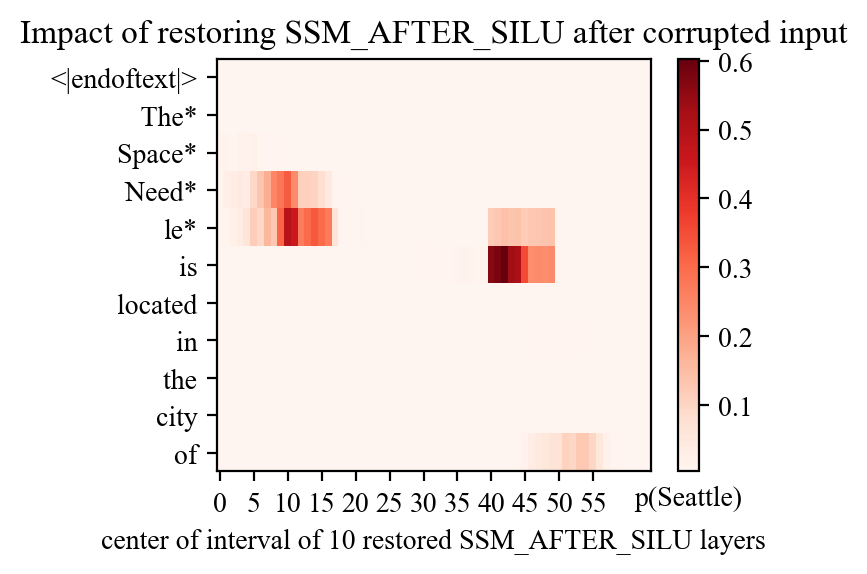

--------------------------------------------------------------------------------
mamba_block_hook='ssm_after_ssm'


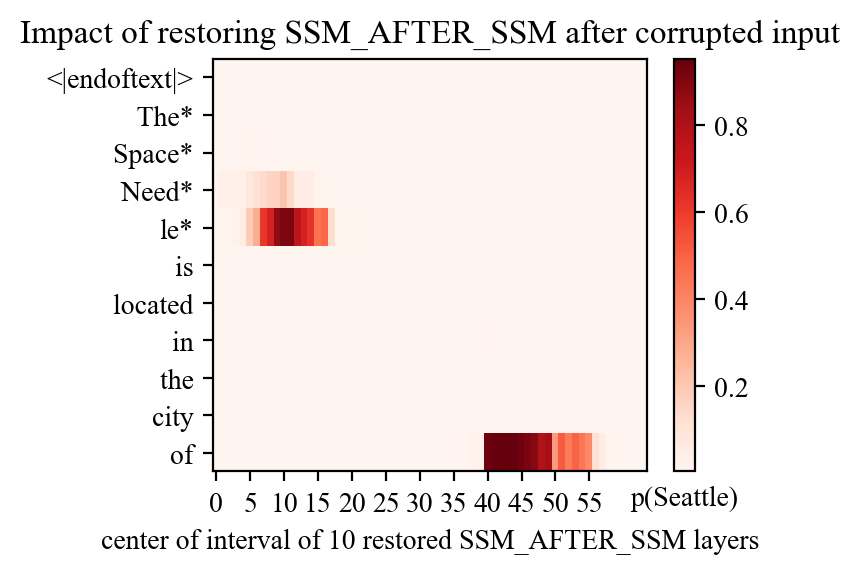

--------------------------------------------------------------------------------
mamba_block_hook='mlp_after_up_proj'


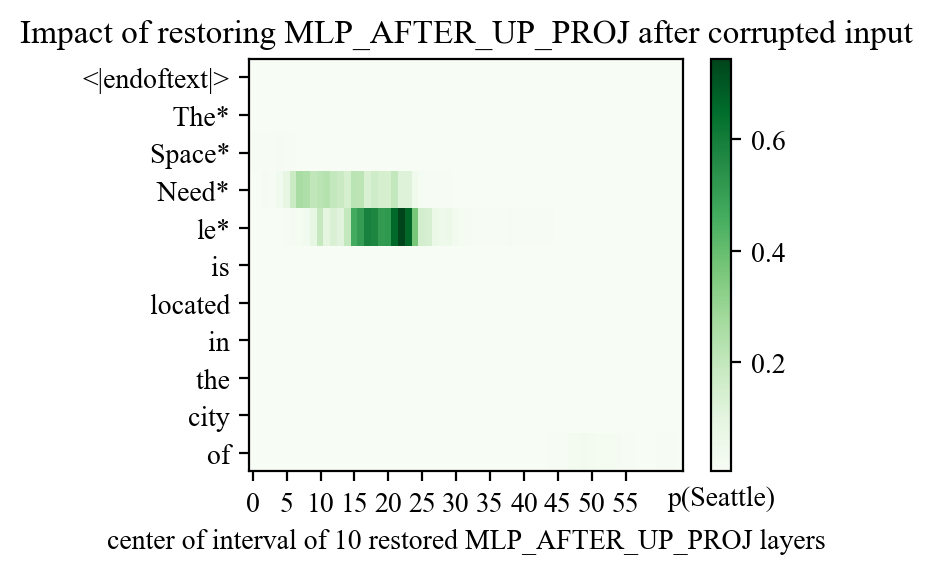

--------------------------------------------------------------------------------
mamba_block_hook='mlp_after_silu'


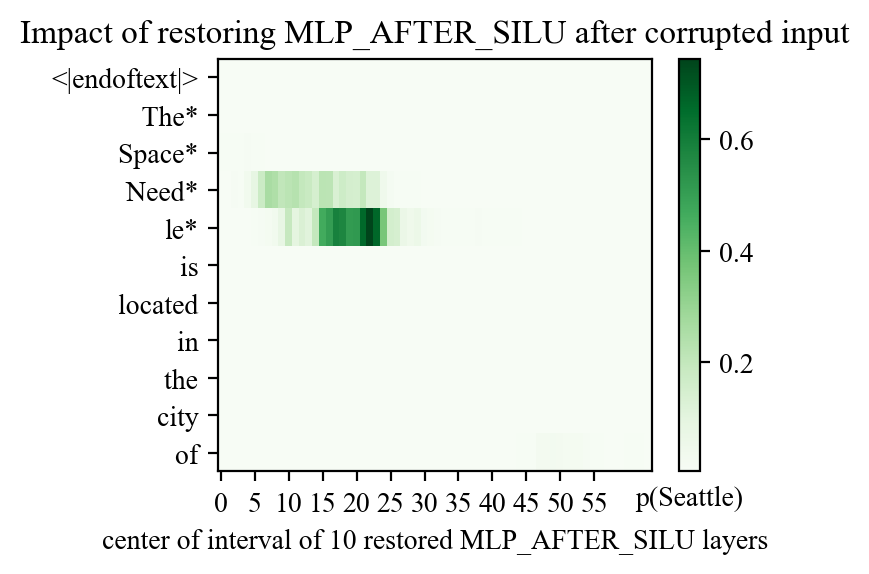

--------------------------------------------------------------------------------
mamba_block_hook='before_down_proj'


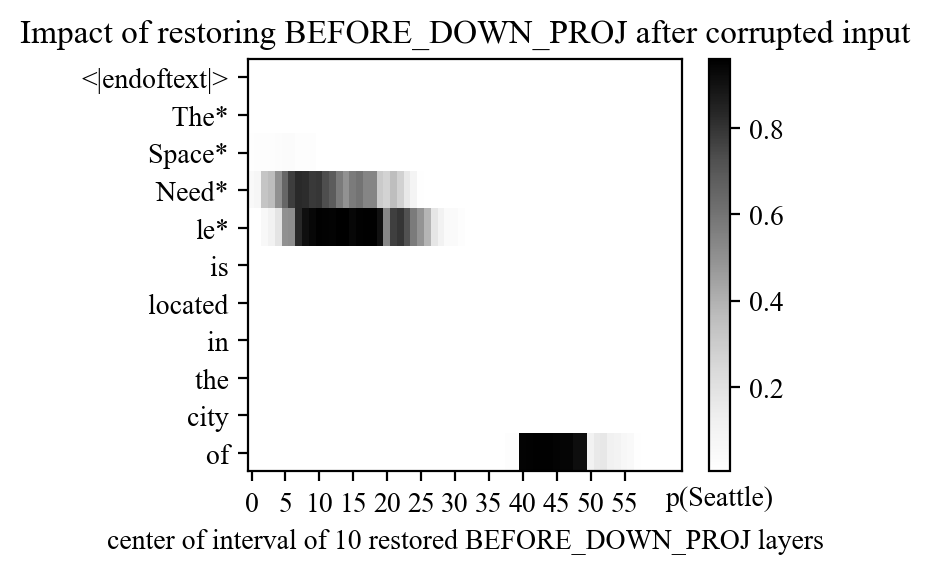

--------------------------------------------------------------------------------
mamba_block_hook='after_down_proj'


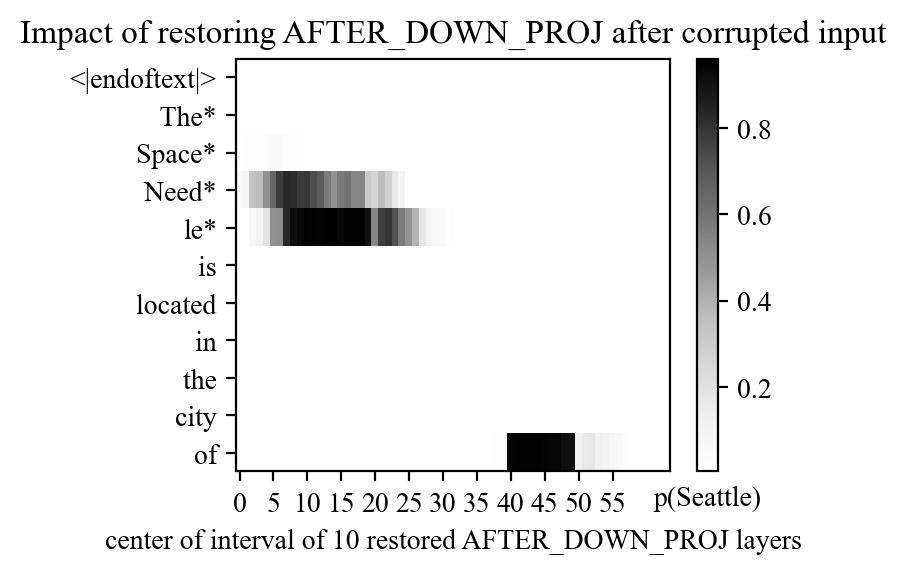

In [43]:
from src.hooking.mamba import MambaBlock_Hook_Points
from typing import get_args

for mamba_block_hook in get_args(MambaBlock_Hook_Points):
    print("-"*80)
    print(f"{mamba_block_hook=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt,
        subject = subject,
        mamba_block_hook=mamba_block_hook
    )
    plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

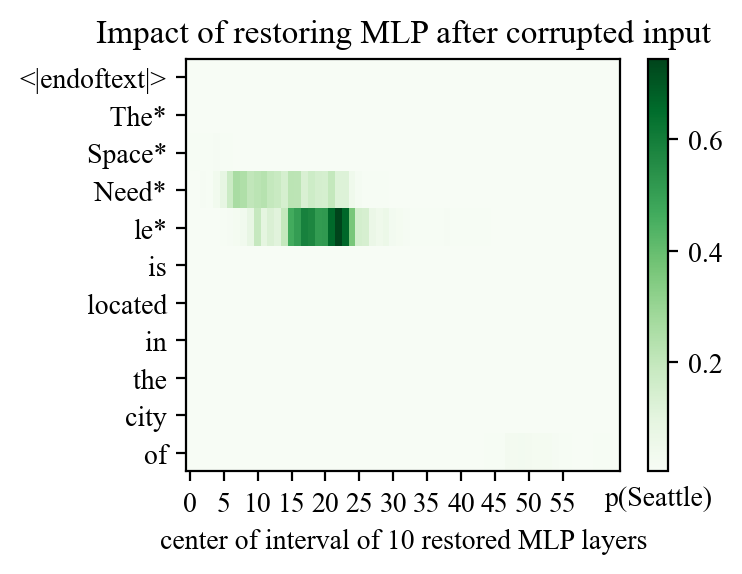

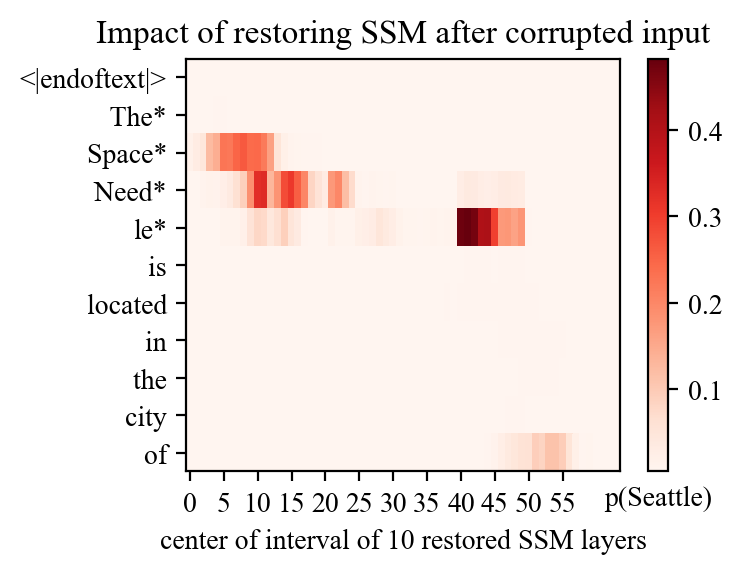

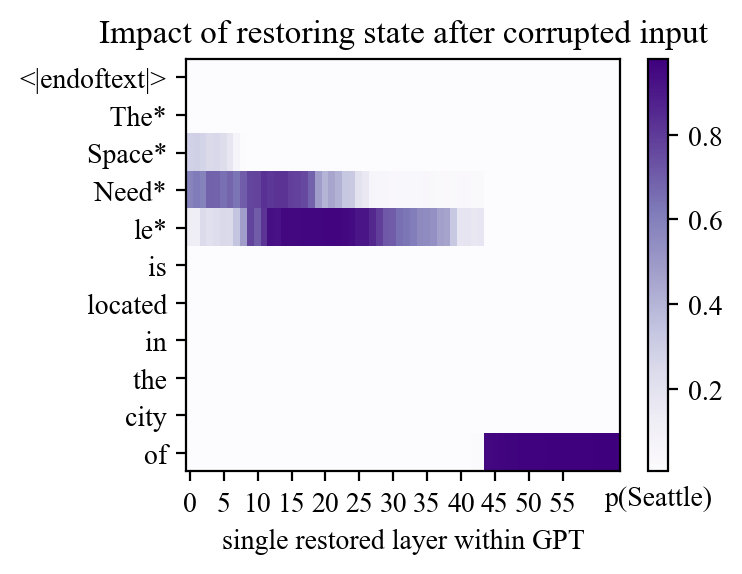

In [28]:
from src.plotting import plot_all_flow

plot_all_flow(
    mt = mt,
    prompt = prompt,
    subject = subject,
)

In [6]:
from src.hooking.mamba import MambaBlockForwardPatcher

In [7]:
from src.utils import tokenizer_utils

patch_layer = 20

prompt_template = mt.tokenizer.eos_token + " {} is located in the city of"
subject = "The Space Needle"
# subject2 = "Louvre Museum"

prompt = prompt_template.format(subject)
# prompt2 = prompt_template.format(subject2)

with tokenizer_utils.set_padding_side(mt.tokenizer, padding_side="left"):
    tokenized = mt.tokenizer(prompt, return_tensors="pt", padding="longest").to(mt.device)

mt.tokenizer.decode(tokenized.input_ids[0][4])

'le'

In [8]:
mt.reset_forward()
outputs = mt.model(input_ids=tokenized.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

[(' Seattle', 0.98),
 (' Se', 0.002),
 (' the', 0.002),
 (' Sea', 0.001),
 (' se', 0.001),
 (' Century', 0.001),
 (' Space', 0.0),
 (' downtown', 0.0),
 (',', 0.0),
 (' Pu', 0.0)]

In [9]:
import types

mt.reset_forward()

retainer = dict()
block = baukit.get_module(mt.model, name = mt.layer_name_format.format(patch_layer) + ".mixer")
block.forward = types.MethodType(
    MambaBlockForwardPatcher(
        retainer = retainer
    ), block
)

outputs = mt.model(input_ids=tokenized.input_ids)
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

[(' Seattle', 0.98),
 (' Se', 0.002),
 (' the', 0.002),
 (' Sea', 0.001),
 (' se', 0.001),
 (' Century', 0.001),
 (' Space', 0.0),
 (' downtown', 0.0),
 (',', 0.0),
 (' Pu', 0.0)]

In [10]:
for k, v in retainer.items():
    print(f"{k=} {v.shape=}")

k='ssm_after_up_proj' v.shape=torch.Size([1, 11, 5120])
k='mlp_after_up_proj' v.shape=torch.Size([1, 11, 5120])
k='ssm_after_conv1D' v.shape=torch.Size([1, 11, 5120])
k='ssm_after_silu' v.shape=torch.Size([1, 11, 5120])
k='ssm_after_ssm' v.shape=torch.Size([1, 11, 5120])
k='mlp_after_silu' v.shape=torch.Size([1, 11, 5120])
k='before_down_proj' v.shape=torch.Size([1, 11, 5120])
k='after_down_proj' v.shape=torch.Size([1, 11, 2560])


In [11]:
from src.functional import get_h

mt.reset_forward()
h = get_h(
    mt = mt,
    prompt = prompt,
    subject = subject,
    layers = [mt.layer_name_format.format(patch_layer) + ".mixer"],
)

torch.allclose(h[mt.layer_name_format.format(patch_layer) + ".mixer"], retainer["after_down_proj"][:, 4])

True

In [12]:
prompt = prompt_template.format("Statue of Liberty")
prompt_2 = prompt_template.format("Louvre Museum")

tokenized = mt.tokenizer(
    # prompt, 
    [prompt, prompt_2],
    return_tensors="pt", padding="longest").to(mt.device)

print(tokenized.input_ids.shape)

mt.tokenizer.decode(tokenized.input_ids[0][4])

torch.Size([2, 11])


' Liberty'

In [13]:
mt.reset_forward()

block = baukit.get_module(mt.model, name = mt.layer_name_format.format(patch_layer) + ".mixer")
block.forward = types.MethodType(
    MambaBlockForwardPatcher(
        patch_spec = {4 : retainer["after_down_proj"][:, 4]},
        patch_hook = "after_down_proj"
    ), block
)

outputs = mt.model(input_ids=tokenized.input_ids[0][None])
logits = outputs[0][-1]
functional.interpret_logits(tokenizer=mt.tokenizer, logits = logits, get_proba=True)

[(' New', 0.717),
 (' Liberty', 0.052),
 (' Stat', 0.014),
 (' Manhattan', 0.012),
 (' Paris', 0.008),
 (' Jersey', 0.007),
 (',', 0.005),
 (' United', 0.005),
 (' NY', 0.004),
 (' USA', 0.003)]